# Setup-import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

## Define Utilities

In [4]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Data loading 


In [5]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock.index = pd.to_datetime(apple_stock.index)

[*********************100%%**********************]  1 of 1 completed


In [6]:
apple_stock

,Adj Close,Volume
Date,,
2010-01-04,6.461975,493729600
2010-01-05,6.473149,601904800
2010-01-06,6.370186,552160000
2010-01-07,6.358407,477131200
2010-01-08,6.400681,447610800
...,...,...
2024-06-27,214.100006,49772700
2024-06-28,210.619995,82542700
2024-07-01,216.750000,60402900


In [7]:
# Calculate daily returns
apple_stock['Return'] = apple_stock['Adj Close'].pct_change()

# Drop missing values
apple_stock.dropna(inplace=True)

# Features: Using previous day's return and other technical indicators as features
apple_stock['Lag1'] = apple_stock['Return'].shift(1)
apple_stock['Lag2'] = apple_stock['Return'].shift(2)
apple_stock['SMA10'] = apple_stock['Adj Close'].rolling(window=10).mean()
apple_stock['SMA50'] = apple_stock['Adj Close'].rolling(window=50).mean()
apple_stock.dropna(inplace=True)

C:\Users\12436\AppData\Local\Temp\ipykernel_6040\1898332434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['Return'] = apple_stock['Adj Close'].pct_change()
C:\Users\12436\AppData\Local\Temp\ipykernel_6040\1898332434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock.dropna(inplace=True)
C:\Users\12436\AppData\Local\Temp\ipykernel_6040\1898332434.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [8]:
apple_stock

,Adj Close,Volume,Return,Lag1,Lag2,SMA10,SMA50
Date,,,,,,,
2010-03-17,6.767245,450956800,-0.001470,0.002725,-0.012180,6.706584,6.255130
2010-03-18,6.783248,342109600,0.002365,-0.001470,0.002725,6.748675,6.261332
2010-03-19,6.710782,559445600,-0.010683,0.002365,-0.001470,6.758640,6.268144
2010-03-22,6.786269,456419600,0.011249,-0.010683,0.002365,6.775760,6.276702
2010-03-23,6.895270,602431200,0.016062,0.011249,-0.010683,6.791884,6.286593
...,...,...,...,...,...,...,...
2024-06-27,214.100006,49772700,0.003986,0.019993,0.004468,211.942001,189.750101
2024-06-28,210.619995,82542700,-0.016254,0.003986,0.019993,211.580000,190.607052
2024-07-01,216.750000,60402900,0.029105,-0.016254,0.003986,212.006000,191.605777


## Train-test split

In [16]:
train = apple_stock[apple_stock.index <= '2024-01-01']
test = apple_stock[apple_stock.index > '2024-01-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (3472, 7)
Test set size: (127, 7)


In [17]:
features = ['Lag1', 'Lag2', 'SMA10', 'SMA50']
target = 'Return'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
# !pip install xgboost

In [51]:
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [53]:
df_xgboost = pd.DataFrame({
    'Actual data': y_test,
    'predicted data': y_pred
}, index=y_test.index)

In [54]:
df_xgboost['actual binary'] = np.where(df_xgboost['Actual data']>0,1,0)
df_xgboost['predicted binary'] = np.where(df_xgboost['predicted data']>0,1,0)
df_xgboost

,Actual data,predicted data,actual binary,predicted binary
Date,,,,
2024-01-02,-0.035787,-0.003449,0,0
2024-01-03,-0.007488,-0.015868,0,0
2024-01-04,-0.012700,-0.001697,0,0
2024-01-05,-0.004013,-0.003490,0,0
2024-01-08,0.024175,-0.000282,1,0
...,...,...,...,...
2024-06-27,0.003986,-0.001025,1,0
2024-06-28,-0.016254,-0.001991,0,0
2024-07-01,0.029105,-0.002814,1,0


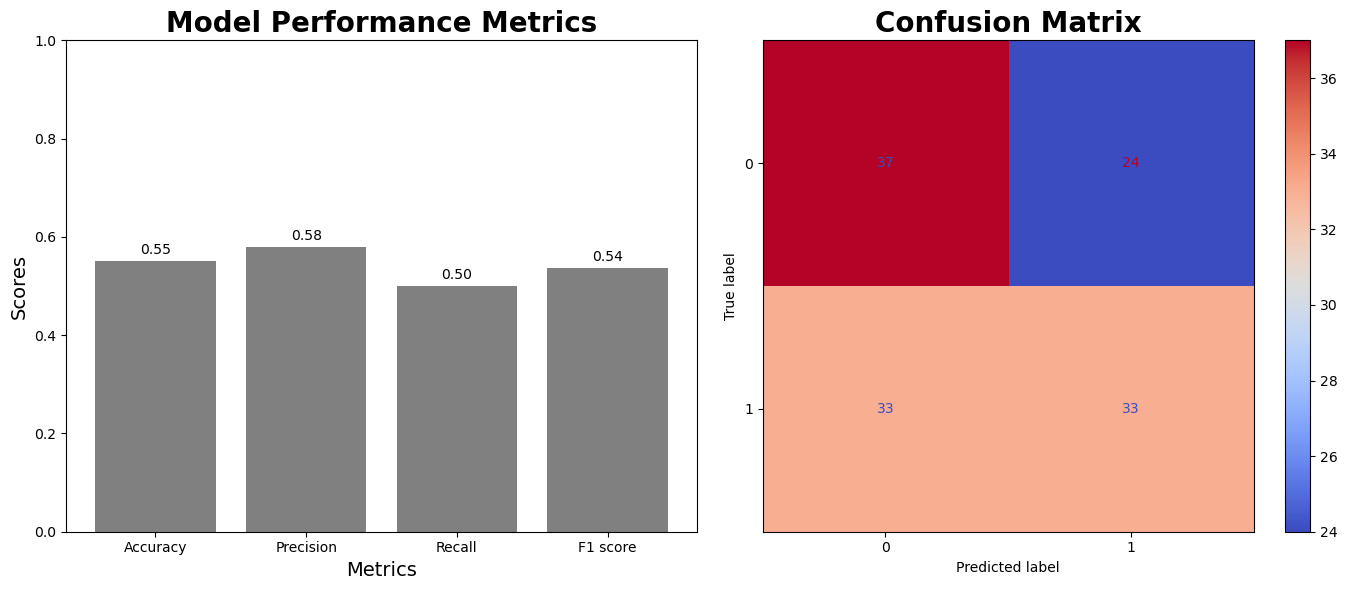

In [55]:
plot_model_performance(df_xgboost['predicted binary'], df_xgboost['actual binary'])